In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [25]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date.fromisoformat(most_recent_date) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
last_twelve_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_twelve_df = pd.DataFrame(last_twelve_results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
last_twelve_df = last_twelve_df.sort_values('Date')
last_twelve_df

,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


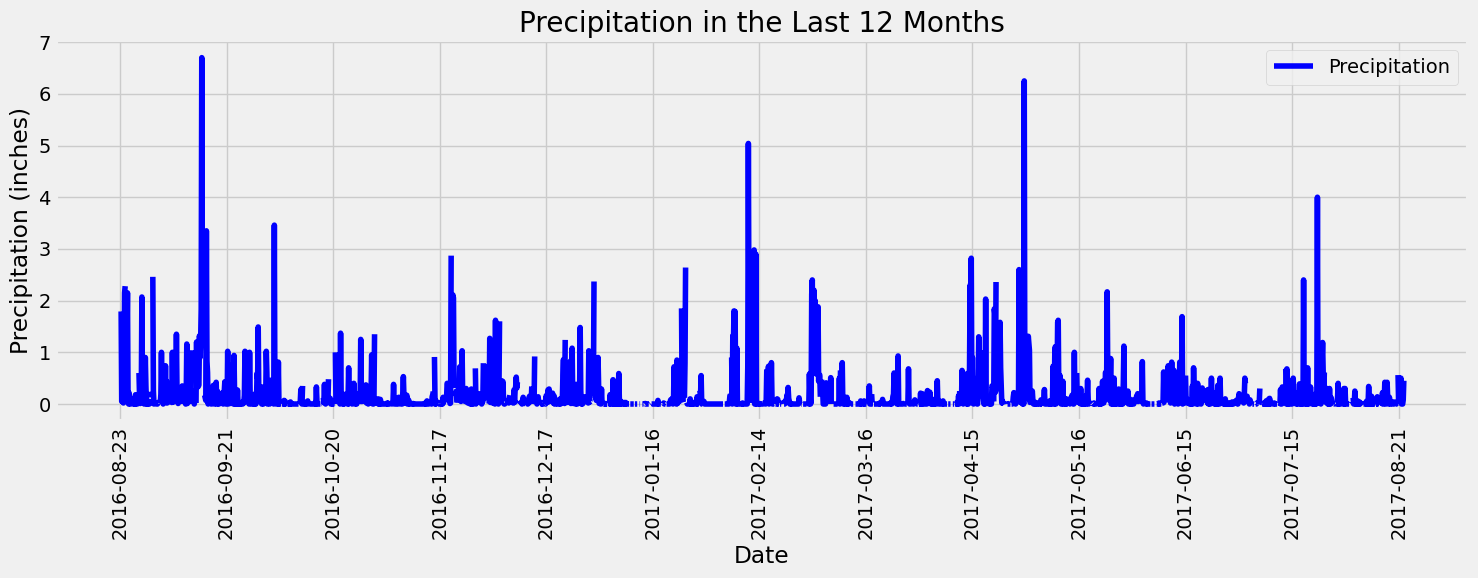

In [30]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = last_twelve_df.plot(x='Date', y='Precipitation', figsize=(15, 6), color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')

# Calculate data points on X axis
num_data_points = len(last_twelve_df)
step_size = num_data_points // 12

# Set the X axis tick locations and labels
tick_indexes = np.arange(0, num_data_points, step_size)
tick_labels = last_twelve_df['Date'].iloc[tick_indexes]
ax.set_xticks(tick_indexes)
ax.set_xticklabels(tick_labels, rotation=90)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = last_twelve_df['Precipitation'].describe()
pd.DataFrame(summary_df)

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

In [34]:
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

# For loop to print most active stations
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station} | Count: {count}")

Most Active Stations:
Station: USC00519281 | Count: 2772
Station: USC00519397 | Count: 2724
Station: USC00513117 | Count: 2709
Station: USC00519523 | Count: 2669
Station: USC00516128 | Count: 2612
Station: USC00514830 | Count: 2202
Station: USC00511918 | Count: 1979
Station: USC00517948 | Count: 1372
Station: USC00518838 | Count: 511


In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

In [36]:
# First, we gather the station ID from the previous data
top_active_station = active_stations[0][0]
top_active_station

'USC00519281'

In [37]:
# Gather minimum, max, and average from the "tobs" temperature observation column 
# Then, filter the data by the top_active_station, which is the station ID needed
top_station_data = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).\
filter(Measurement.station == top_active_station).all()
top_station_data

[(54.0, 85.0, 71.66378066378067)]

In [38]:
# Display and print the data
print(f"The lowest temperature is {top_station_data[0][0]}°F. The highest is {top_station_data[0][1]}°F. Average is {top_station_data[0][2]}°F.")


The lowest temperature is 54.0°F. The highest is 85.0°F. Average is 71.66378066378067°F.


In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [40]:
# Query that pulls tobs column and filters by top_active_station using the one_year_ago time frame created above.
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == top_active_station).\
    filter(Measurement.date >= one_year_ago).all()
temperatures_df = pd.DataFrame(temperature_data)
temperatures_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


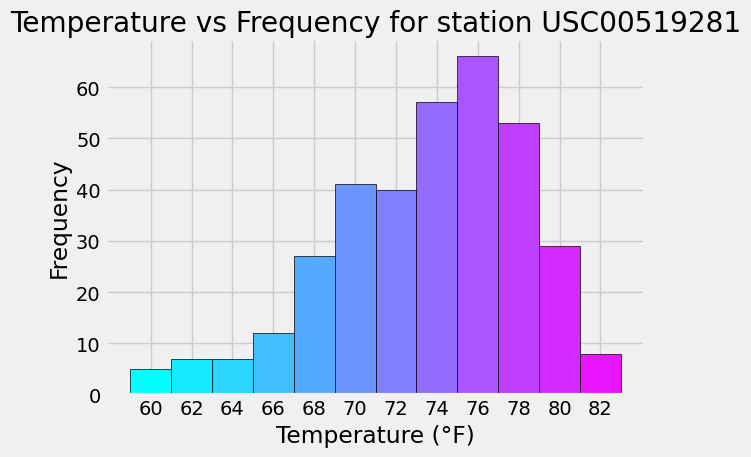

In [41]:
# Display the histogram with a cool-to-warm gradient by normalizing and using the "cool" color map.
fig, ax = plt.subplots()
n, bins, patches = ax.hist(temperatures_df['tobs'], bins=12, edgecolor='black')
norm = plt.Normalize(np.min(bins), np.max(bins))
colors = plt.cm.cool(norm(bins))

# Set the color of each histogram bar based on the gradient
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)


plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature vs Frequency for station {top_active_station}')

# Even numbers on X ticks for better visualization
even_ticks = range(60, 84, 2)
plt.xticks(even_ticks)
plt.tight_layout()

plt.show()

# Close Session

In [42]:
# Close Session
session.close()